One can open this tutorial in Google Colab (is recommended)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LuchnikovI/RQC_School_Rapid_prototyping/3_Ground_state_of_spin_chain.ipynb)

## Here we import all necessary libraries.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.style as style

# Library to build progress bar for optimization
from tqdm import tqdm

# This library allows us to find ground state
# of a spin system with DMRG algorithm.
# It is necessary to compare our simple implementation
# with DMRG algorithm
!pip install mpnum
import mpnum as mp

In this notebook we search for the ground state of a spin chain with local Hamiltonian. One can do it by minimizing of variational energy as follows:

$$|g\rangle = \underset{|\psi\rangle}{\rm{argmin}}\frac{\langle\psi|H|\psi\rangle}{\langle\psi|\psi\rangle},$$

where $|\psi\rangle$ is parametrized by MPS. To perform this optimization below we introduce a class mp_tensor that allows to perform all basic operations with tensors in matrix product format. In the illustration below there is an explanation of the structure of mp_tensor class.
![broadcasting.png](https://github.com/LuchnikovI/RQC_School_Rapid_prototyping/blob/master/images/mp_tensor.png?raw=1)

In [98]:
class mp_tensor:
    """Class allows to operate with matrix product tensors.
    Args:
        kernels: list of tensors, each tensor has shape 
            (left_bond, ..., right_bond), where (...) can be any."""

    def __init__(self, kernels):

        # list of kernels
        self.kernels = kernels
        # local shape of kernel
        self.local_shape = kernels[0].shape[1:-1]
        # number of local indices of each kernel
        self.local_rank = len(self.local_shape)
        # number of kernels
        self.number_of_kers = len(kernels)
        self.dtype = kernels[0].dtype

        '''Here we check whether all local shapes are the
        same and all bond dimensions are consistent.'''
        right_dim = 1
        for kernel in kernels:
            flag = kernel.shape[1:-1] == self.local_shape
            assert flag, 'local shapes are different'
            flag = kernel.shape[0] == right_dim
            assert flag, 'hidden dims are inconsistent'
            right_dim = kernel.shape[-1]
        flag = right_dim == 1
        assert flag, 'hidden dims are inconsistent'

    def einsum(self, string, t):
        '''Acts like the standard einsum function but only on
        local indices. The same for each kernel.
        Args:
            string: string, that shows details of convolution
            t: mp_tensor that is consistent wirh self
        Returns:
            new mp_tensor, result of a convolution'''

        # preparation of a string
        first_tensor, second_tensor = string.split(',')
        second_tensor, result = second_tensor.split('->')
        tt_string = 'a' + first_tensor + 'b' +\
        ',' + 'c' + second_tensor + 'd' + '->' + 'ac' + result + 'bd'

        # application of the einsum function to all kernels
        new_kernels = []
        for i in range(len(self.kernels)):
            conv = tf.einsum(tt_string, self.kernels[i], t.kernels[i])
            conv = tf.reshape(conv, (conv.shape[0]*conv.shape[1]) +\
                                     conv.shape[2:-2] +\
                                     (conv.shape[-2]*conv.shape[-1]))
            new_kernels.append(conv)
            
        return mp_tensor(new_kernels)
    
    def log_convolve(self):
        '''Convolves a tensor network without free indices.
        Returns:
            list with two complex scalar values, the first value
            is the phase multiplier exp(i*phi) of a result
            and the second value is log(|result|)'''

        # checking whether tn has free indices or not
        assert len(self.local_shape) == 0, 'incorrect local shape'
        '''Here we calculate the phase multiplier exp(i*phi) of a result
        and log(|result|) instead of just a value of convolution.
        It is done in order to avoid problems with overflow and underflow
        during computation. Value of the convolution can be reconstructed
        as follows: exp(i*phi)*exp(log(|result|))'''
        left = tf.constant([1], dtype=self.dtype)
        log_norm = 0
        for kernel in self.kernels:
            left = tf.tensordot(left, kernel, axes=1)
            norm = tf.linalg.norm(left)
            left = left / norm
            log_norm = log_norm + tf.math.log(norm)
        return left, log_norm

    def reshape(self, shape):
        """Reshapes local indices (in place) of mp_tensor.
        Args:
            shape: tuple, new local shape of all kernels"""

        for i in range(self.number_of_kers):
            full_shape = (self.kernels[i].shape[0],) +\
                          shape + (self.kernels[i].shape[-1],)
            self.kernels[i] = tf.reshape(self.kernels[i], full_shape)
        self.local_shape = shape
        self.local_rank = len(shape)

    def transpose(self, order):
        """Transposes local indices (in place) of mp_tensor.
        Args:
            shape: tuple, new local shape of all kernels"""

        full_order = (0,) + tuple(map(lambda x: x+1, order)) +\
                     (self.local_rank + 1,)
        for i in range(self.number_of_kers):
            self.kernels[i] = tf.transpose(self.kernels[i], full_order)
        self.local_shape = self.kernels[0].shape[1:-1]

    def take_log_mps_element(self, indices):
        """Returns value of MPS for a given set of indices.
        Args:
            indices: list with indices
        list with two complex scalar values, the first value
            is the phase multiplier exp(i*phi) of a result
            and the second value is log(|result|)"""

        # checking whether a given mp_tensor is mps
        assert len(self.local_shape) == 1, 'incorrect local shape'
        left = tf.constant([1], dtype=self.dtype)
        '''Here we again calculate the phase multiplier exp(i*phi) of a result
        and log(|result|) instead of just a value of an MPS element.
        It is done in order to avoid problems with overflow and underflow
        during computation. Value of an MPS element can be reconstructed
        as follows: exp(i*phi)*exp(log(|result|))'''
        log_norm = 0
        for i, ind in enumerate(indices):
            left = tf.tensordot(left, self.kernels[i][:, ind, :], axes=1)
            norm = tf.linalg.norm(left)
            left = left / norm
            log_norm = log_norm + tf.math.log(norm)
        return left, log_norm

    def conj(self):
        '''Return conjugate mp_tensor'''
        return mp_tensor(list(map(tf.math.conj, self.kernels)))

Here we prepare MPO form of the TFI hamiltonian that has the following form:

$$H = \sum_{i=1}^{N-1}\sigma^i_z\sigma_z^{i+1} + \sum_{i=1}^N h_x\sigma_x^{i} + h_z\sigma_z^i$$

In [101]:
#=================Parameters=================#
h_z = 0.3  # z component of a magnetic field
h_x = 1.  # x component of a magnetic field
N = 32  # number of spins
bond_dim = 28  # bond dimension
#============================================#

# Pauli matrices
sigma_x = tf.constant([[0, 1], [1, 0]], dtype=tf.complex128)
sigma_y = tf.constant([[0 + 0j, -1j], [1j, 0 + 0j]], dtype=tf.complex128)
sigma_z = tf.constant([[1, 0], [0, -1]], dtype=tf.complex128)

# identical matrix
idm = tf.eye(2, dtype=tf.complex128)

# matrix filled by zeros
z = tf.zeros((2, 2), dtype=tf.complex128)

# generalized observable
obs = tf.transpose(tf.convert_to_tensor([idm, sigma_x, sigma_y, sigma_z]), (1, 0, 2))

'''Here we construct MPO representation of a TFI Hamiltonian'''

# MPO of hamiltonian, middle part
h_mid = tf.convert_to_tensor([[idm, z, z], [sigma_z, z, z], [h_x * sigma_x + h_z * sigma_z, sigma_z, idm]])
h_mid = tf.transpose(h_mid, (0, 2, 3, 1))

# MPO of hamiltonian, right part
h_right = tf.convert_to_tensor([idm, sigma_z, h_x * sigma_x + h_z * sigma_z])
h_right = h_right[..., tf.newaxis]

# MPO of hamiltonian, left part
h_left = tf.convert_to_tensor([h_x * sigma_x + h_z * sigma_z, sigma_z, idm])
h_left = tf.transpose(h_left, (1, 2, 0))
h_left = h_left[tf.newaxis]

# Hamiltonian in a form of mp_tensor
H = mp_tensor([h_left] + (N - 2) * [h_mid] + [h_right])

Here we solve the following optimization problem

$$|g\rangle = \underset{|\psi\rangle}{\rm{argmin}}\frac{\langle\psi|H|\psi\rangle}{\langle\psi|\psi\rangle},$$

using automatic differentiation and Adam optimizer.

In [ ]:
#=============Parameters=============#
iters = 1000  # number of iterations
lr = 0.1  # optimization step size
#====================================#

# set of tf.Variables that parametrize MPS representation of a state
re_mid = [tf.Variable(tf.random.normal((bond_dim, 2, bond_dim), dtype=tf.float64)) for _ in range(N - 2)]
im_mid = [tf.Variable(tf.random.normal((bond_dim, 2, bond_dim), dtype=tf.float64)) for _ in range(N - 2)]
re_left = [tf.Variable(tf.random.normal((1, 2, bond_dim), dtype=tf.float64))]
im_left = [tf.Variable(tf.random.normal((1, 2, bond_dim), dtype=tf.float64))]
re_right = [tf.Variable(tf.random.normal((bond_dim, 2, 1), dtype=tf.float64))]
im_right = [tf.Variable(tf.random.normal((bond_dim, 2, 1), dtype=tf.float64))]
re = re_left + re_mid + re_right
im = im_left + im_mid + im_right

# aux. function that helps to convert re and im parts of kernels to
# complex kernels
cmplx = lambda x: tf.complex(x[0], x[1])
# optimizer
opt = tf.optimizers.Adam(lr)
#  this list will be filled by values of energy per iteration
energies = []
# optimization loop
for _ in tqdm(range(iters)):
    with tf.GradientTape() as tape:
        # state in mps form
        mps = mp_tensor(list(map(cmplx, zip(re, im))))
        # conjugated state
        mps_conj = mps.conj()
        # <psi|H|psi>
        H_mps = H.einsum('ij,j->i', mps)
        mps_h_mps = mps_conj.einsum('i,i->', H_mps)
        mps_h_mps_sign, mps_h_mps_log_norm = mps_h_mps.log_convolve()
        # <psi|psi>
        mps_mps = mps_conj.einsum('i,i->', mps)
        mps_mps_sign, mps_mps_log_norm = mps_mps.log_convolve()
        # <psi|H|psi> / <psi|psi>
        energy = mps_mps_sign * mps_h_mps_sign * tf.math.exp(mps_h_mps_log_norm - mps_mps_log_norm)
        energy = tf.math.real(energy)
    # gradient of energy with respect to variables
    grad = tape.gradient(energy, re + im)
    # adding energy per site to the list
    energies.append(energy / N)
    # optimization step
    opt.apply_gradients(zip(grad, re + im))

Here we solve the same optimization problem, but by using DMRG algorithm implemented in mp_num library.

In [103]:
import functools
import scipy
def ham(N, h_x, h_z):
    
    #two-site zz part
    h_mpo = mp.MPArray.from_kron([sigma_z.numpy(), sigma_z.numpy()])
    #an empty list will be filled by local terms
    h = []
    
    #adding zz terms to the hamiltonian
    for startpos in range(N - 1):
        left = [mp.MPArray.from_kron([idm.numpy()] * startpos)] if startpos > 0 else []
        right = [mp.MPArray.from_kron([idm.numpy()] * (N - 2 - startpos))] if N - 2 - startpos > 0 else []
        h_at_startpos = mp.chain(left + [h_mpo] + right)
        h.append(h_at_startpos)
    
    #adding x terms to the hamiltonian
    for startpos in range(N):
        left = [mp.MPArray.from_kron([idm.numpy()] * startpos)] if startpos > 0 else []
        right = [mp.MPArray.from_kron([idm.numpy()] * (N - 1 - startpos))] if N - 1 - startpos > 0 else []
        h_at_startpos = mp.chain(left + [mp.MPArray.from_array_global(h_x * sigma_x.numpy())] + right)
        h.append(h_at_startpos)
    
    #adding z terms to the hamiltonian
    for startpos in range(N):
        left = [mp.MPArray.from_kron([idm.numpy()] * startpos)] if startpos > 0 else []
        right = [mp.MPArray.from_kron([idm.numpy()] * (N - 1 - startpos))] if N - 1 - startpos > 0 else []
        h_at_startpos = mp.chain(left + [mp.MPArray.from_array_global(h_z * sigma_z.numpy())] + right)
        h.append(h_at_startpos)
        
    H = h[0]
    for local_term in h[1:]:
        H = H + local_term
    out, _ = H.compression(method='svd', relerr=1e-10)
    return out

mp_H = ham(N, h_x, h_z)
eigs = functools.partial(scipy.sparse.linalg.eigsh, k=1, tol=1e-6, which='SA')
dmrg_e = mp.linalg.eig(mp_H, 5, startvec_rank=28, eigs=eigs)[0] / N

Here we plot the difference between variational energy found by DMRG algorithm and variational energy found by our simple automatic differentiation based algorithm. One can see, that our algorithm converges to variational energy found by DMRG algorithm.

Value of energy found by Adam optimizer -1.2701329277280793
Value of energy found by DMRG algorithm -1.2701487080837819


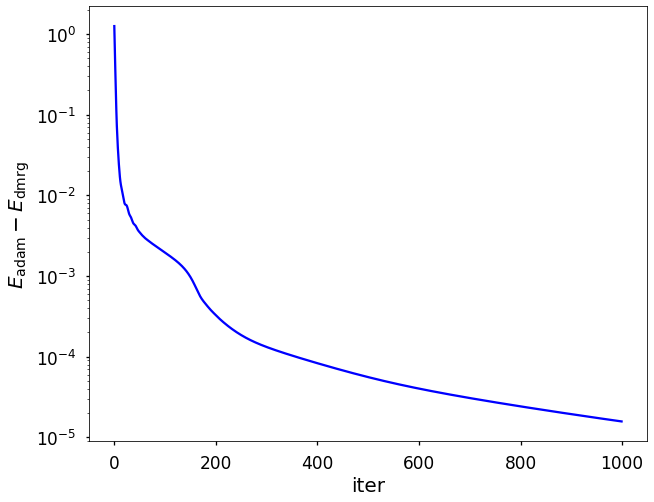

In [110]:
style.use('seaborn-talk')
fig = plt.figure(figsize=(10, 8))
plt.tick_params(axis='both', which='both', labelsize=17)
plt.plot(energies - dmrg_e, 'b')
plt.xlabel('iter', fontsize=20)
plt.ylabel(r'$E_{\rm adam} - E_{\rm dmrg}$', fontsize=20)
plt.yscale('log')
print('Value of energy found by Adam optimizer {}'.format(energies[-1][0]))
print('Value of energy found by DMRG algorithm {}'.format(dmrg_e))
plt.savefig('egergy_evolution.pdf')

Here we calculate correlation functions.

In [111]:
# mps_obs_mps is a set of all correlation functions
mp_obs = mp_tensor(N * [obs[tf.newaxis, ..., tf.newaxis]])
obs_mps = mp_obs.einsum('ikj,j->ik', mps)
mps_obs_mps = mps_conj.einsum('i,ik->k', obs_mps)
xx = []  # will be filled by <sigma_x, sigma_x>
yy = []  # will be filled by <sigma_y, sigma_y>
zz = []  # will be filled by <sigma_z, sigma_z>
x = []  # will be filled by <sigma_x>
y = []  # will be filled by <sigma_y>
z = []  # will be filled by <sigma_z>
for i in range(N-1):
    inds = [1] + i * [0] + [1] + (N - 2 - i) * [0]
    sign_corr, log_corr = mps_obs_mps.take_log_mps_element(inds)
    corr = sign_corr * mps_mps_sign * tf.math.exp(log_corr - mps_mps_log_norm)
    xx.append(corr)
for i in range(N-1):
    inds = [2] + i * [0] + [2] + (N - 2 - i) * [0]
    sign_corr, log_corr = mps_obs_mps.take_log_mps_element(inds)
    corr = sign_corr * mps_mps_sign * tf.math.exp(log_corr - mps_mps_log_norm)
    yy.append(corr)
for i in range(N-1):
    inds = [3] + i * [0] + [3] + (N - 2 - i) * [0]
    sign_corr, log_corr = mps_obs_mps.take_log_mps_element(inds)
    corr = sign_corr * mps_mps_sign * tf.math.exp(log_corr - mps_mps_log_norm)
    zz.append(corr)
for i in range(N):
    inds = N * [0]
    inds[i] = 1
    sign_corr, log_corr = mps_obs_mps.take_log_mps_element(inds)
    corr = sign_corr * mps_mps_sign * tf.math.exp(log_corr - mps_mps_log_norm)
    x.append(corr)
for i in range(N-1):
    inds = N * [0]
    inds[i] = 2
    sign_corr, log_corr = mps_obs_mps.take_log_mps_element(inds)
    corr = sign_corr * mps_mps_sign * tf.math.exp(log_corr - mps_mps_log_norm)
    y.append(corr)
for i in range(N-1):
    inds = N * [0]
    inds[i] = 3
    sign_corr, log_corr = mps_obs_mps.take_log_mps_element(inds)
    corr = sign_corr * mps_mps_sign * tf.math.exp(log_corr - mps_mps_log_norm)
    z.append(corr)

Plotting of correlation functions.

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


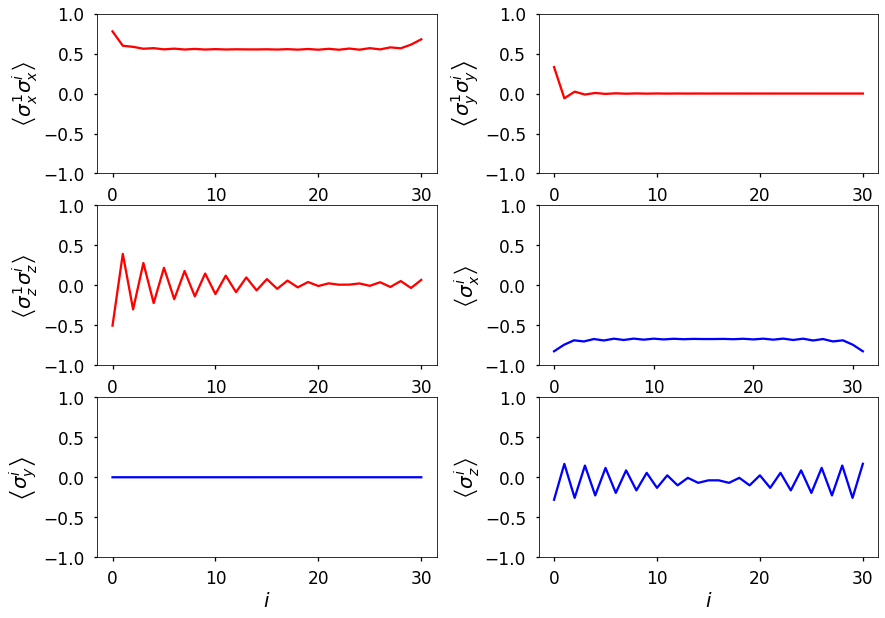

In [112]:
plt.figure(figsize=(14, 10))

plt.subplot(321)
plt.tick_params(axis='both', which='both', labelsize=17)
plt.ylabel(r'$\left\langle\sigma_x^{1}\sigma_x^{i}\right\rangle$', fontsize=20)
plt.plot(xx, 'r')
plt.ylim(top=1, bottom=-1)

plt.subplot(322)
plt.tick_params(axis='both', which='both', labelsize=17)
plt.ylabel(r'$\left\langle\sigma_y^{1}\sigma_y^{i}\right\rangle$', fontsize=20)
plt.plot(yy, 'r')
plt.ylim(top=1, bottom=-1)

plt.subplot(323)
plt.tick_params(axis='both', which='both', labelsize=17)
plt.ylabel(r'$\left\langle\sigma_z^{1}\sigma_z^{i}\right\rangle$', fontsize=20)
plt.xlabel(r'$i$', fontsize=20)
plt.plot(zz, 'r')
plt.ylim(top=1, bottom=-1)

plt.subplot(324)
plt.tick_params(axis='both', which='both', labelsize=17)
plt.ylabel(r'$\left\langle\sigma_x^{i}\right\rangle$', fontsize=20)
plt.xlabel(r'$i$', fontsize=20)
plt.plot(x, 'b')
plt.ylim(top=1, bottom=-1)

plt.subplot(325)
plt.tick_params(axis='both', which='both', labelsize=17)
plt.ylabel(r'$\left\langle\sigma_y^{i}\right\rangle$', fontsize=20)
plt.xlabel(r'$i$', fontsize=20)
plt.plot(y, 'b')
plt.ylim(top=1, bottom=-1)

plt.subplot(326)
plt.tick_params(axis='both', which='both', labelsize=17)
plt.ylabel(r'$\left\langle\sigma_z^{i}\right\rangle$', fontsize=20)
plt.xlabel(r'$i$', fontsize=20)
plt.plot(z, 'b')
plt.ylim(top=1, bottom=-1)

plt.subplots_adjust(wspace=0.3)
plt.savefig('corr_functions.pdf')